In [5]:
import xarray as xr
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

from metpy.plots import SkewT

import matplotlib.pyplot as plt

from skimage.measure import label, regionprops
import pickle as pickle

from scipy import ndimage
import gc

# Read Data

In [7]:
%%capture

#Virtual Temperature
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
file='ensmean_daycycle_ALL_3D_P.nc'
all_P = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_T.nc'
all_T = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_RELHUM.nc'
all_RELHUM = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_QV.nc'
all_QV = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_QC.nc'
all_QC = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_W.nc'
all_W = xr.open_mfdataset(path+file).squeeze()

#TWATER
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
file='ensmean_daycycle_ALL.nc'
all_2D= xr.open_mfdataset(path+file)

#Wet-Day Frequency
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/RCE_300_3km_1006x1006_ALL_ens?/precip_stats/'
file='precip_wd_freq_2D_eq.nc'
all_wd_freq= xr.open_mfdataset(path+file, concat_dim='ens').squeeze()


#Landmask
path = '/scratch/snx3000/davidle/RCE-LND_new/RCE_300_3km_1006x1006_ALL_ens0/output/'
file='lffd2011032100c.nc'
all_const = xr.open_mfdataset(path+file).squeeze()

In [12]:
%%capture

#Virtual Temperature
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
file='ensmean_daycycle_SMALL_3D_P.nc'
small_P = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_T.nc'
small_T = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_RELHUM.nc'
small_RELHUM = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_QV.nc'
small_QV = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_QC.nc'
small_QC = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_W.nc'
small_W = xr.open_mfdataset(path+file).squeeze()

#TWATER
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
file='ensmean_daycycle_SMALL.nc'
small_2D= xr.open_mfdataset(path+file)

#Wet-Day Frequency
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/RCE_300_3km_1006x1006_SMALL_ens?/precip_stats/'
file='precip_wd_freq_2D_eq.nc'
small_wd_freq= xr.open_mfdataset(path+file, concat_dim='ens').squeeze()


#Landmask
path = '/scratch/snx3000/davidle/RCE-LND_new/RCE_300_3km_1006x1006_SMALL_ens0/output/'
file='lffd2011032100c.nc'
small_const = xr.open_mfdataset(path+file).squeeze()

# Create Masks

In [13]:
all_fr_land = all_const.FR_LAND[4:-4,4:-4]
all_land = all_fr_land
all_coast = ndimage.binary_dilation(all_fr_land, iterations=20) - all_fr_land - (ndimage.binary_dilation(all_fr_land, iterations=3) - all_fr_land) #cost is 60km wide
all_ocean = np.ones_like(all_fr_land) - ndimage.binary_dilation(all_fr_land, iterations=20)

#Clip to wet regions
cwv = all_2D.TWATER.mean(axis=(0))
all_wetmask=np.where(cwv > np.percentile(cwv, 50), 1, 0)
all_drymask=np.where(cwv > np.percentile(cwv, 50), 0, 1)

all_wland=np.where(all_wetmask, all_land, 0)
all_wocean=np.where(all_wetmask, all_ocean, 0)
all_coastal_ocean=np.where(all_wetmask, all_coast, 0)
all_dry_ocean=np.where(all_drymask, all_ocean, 0)

In [14]:
small_fr_land = small_const.FR_LAND[4:-4,4:-4]
small_land = small_fr_land
small_coast = ndimage.binary_dilation(small_fr_land, iterations=20) - small_fr_land - (ndimage.binary_dilation(small_fr_land, iterations=3) - small_fr_land) #cost is 60km wide
small_ocean = np.ones_like(small_fr_land) - ndimage.binary_dilation(small_fr_land, iterations=20)

#Clip to wet regions
cwv = small_2D.TWATER.mean(axis=(0))
small_wetmask=np.where(cwv > np.percentile(cwv, 50), 1, 0)
small_drymask=np.where(cwv > np.percentile(cwv, 50), 0, 1)

small_wland=np.where(small_wetmask, small_land, 0)
small_wocean=np.where(small_wetmask, small_ocean, 0)
small_coastal_ocean=np.where(small_wetmask, small_coast, 0)
small_dry_ocean=np.where(small_drymask, small_ocean, 0)

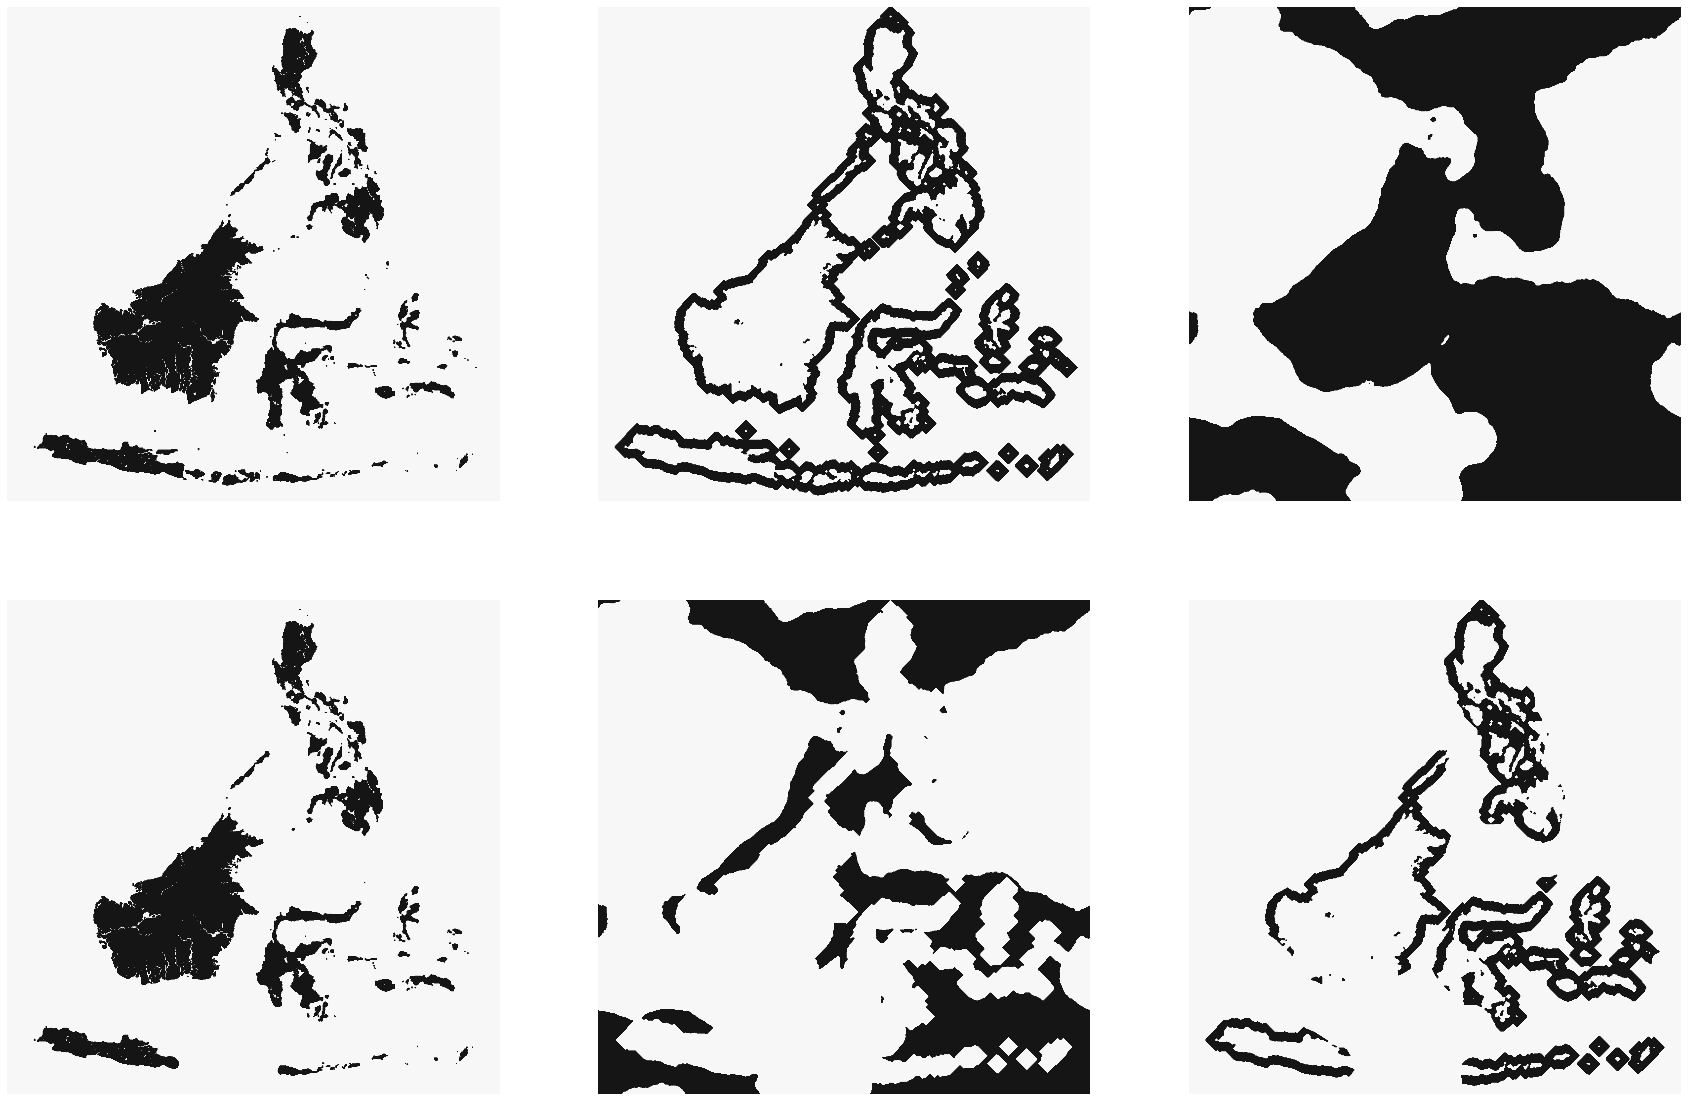

In [15]:
fig = plt.figure(figsize=(30, 20))
plt.rcParams.update({'font.size': 16})
plt.set_cmap('Greys')

plt.subplot(2,3,1)
plt.axis('off')
plt.contourf(all_fr_land)

plt.subplot(2,3,2)
plt.axis('off')
plt.contourf(all_coast)

plt.subplot(2,3,3)
plt.axis('off')

plt.contourf(all_wetmask)

plt.subplot(2,3,4)
plt.axis('off')
plt.contourf(all_wland)

plt.subplot(2,3,5)
plt.axis('off')
plt.contourf(all_wocean)

plt.subplot(2,3,6)
plt.axis('off')
plt.contourf(all_coastal_ocean)



plt.savefig('Masks.pdf')

### Compute Variables

In [16]:
all_Td_s = mpcalc.dewpoint_rh(all_T.T[:,-1,:,:], all_RELHUM.RELHUM[:,-1,:,:])
p_lcl = mpcalc.lcl(all_P.P[:,-1,:,:], all_T.T[:,-1,:,:], all_Td_s)[0]
all_ilcl = (np.abs(all_P.P - p_lcl[:, np.newaxis, ...])).argmin(axis=1)

In [17]:
small_Td_s = mpcalc.dewpoint_rh(small_T.T[:,-1,:,:], small_RELHUM.RELHUM[:,-1,:,:])
p_lcl = mpcalc.lcl(small_P.P[:,-1,:,:], small_T.T[:,-1,:,:], small_Td_s)[0]
small_ilcl = (np.abs(small_P.P - p_lcl[:, np.newaxis, ...])).argmin(axis=1)

### Properties at the LCL

In [18]:
def composite_lcl_diurnal_cycle(fld,index):
    #This is slow, but requires less memory than np.take()
    out= np.empty(np.shape(index), dtype=float)
    for t,k,j,i in np.ndindex(np.shape(fld)):
        out[t,j,i] = fld[t,index[t,j,i],j,i]
    return out

In [19]:
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
try:
    all_T_lcl  = pickle.load( open( path+'T_lcl.pkl', "rb" ) )
except:
    all_T_lcl = composite_lcl_diurnal_cycle(all_T.T.values,all_ilcl.values)
    with open(path+'T_lcl.pkl', 'wb') as pickle_file:
        pickle.dump(all_T_lcl, pickle_file)
        
try:
    small_T_lcl  = pickle.load( open( path+'T_lcl_SMALL.pkl', "rb" ) )
except:
    small_T_lcl = composite_lcl_diurnal_cycle(small_T.T.values,small_ilcl.values)
    with open(path+'T_lcl_SMALL.pkl', 'wb') as pickle_file:
        pickle.dump(small_T_lcl, pickle_file)

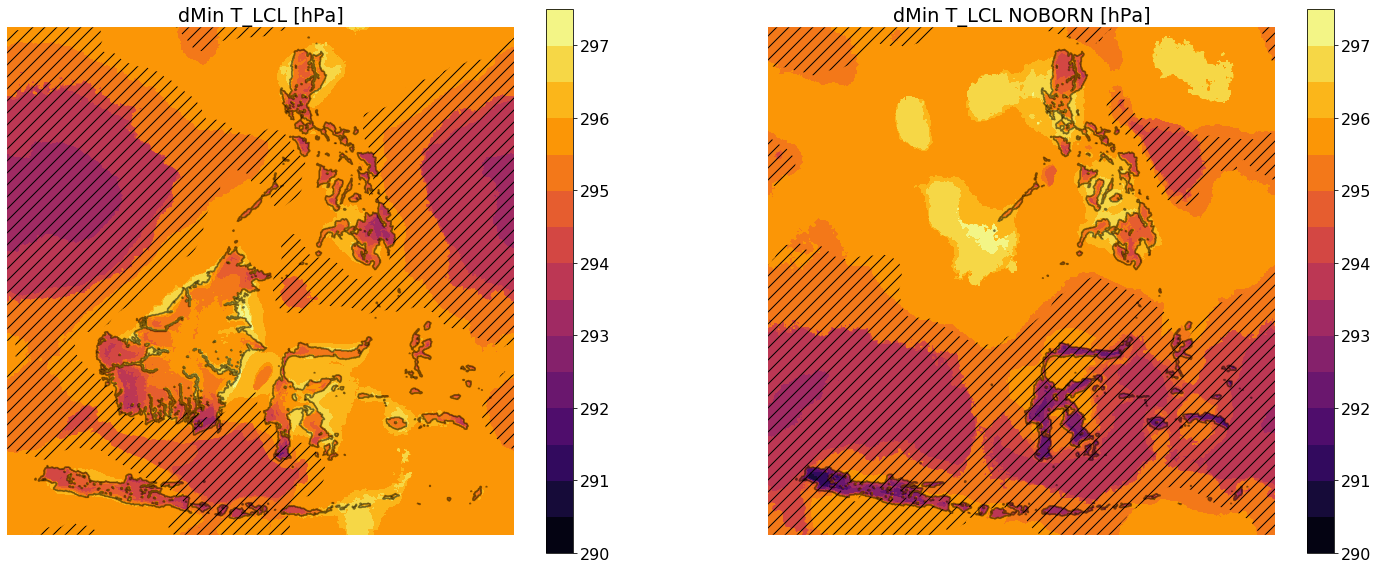

In [28]:
fig = plt.figure(figsize=(25, 10))
plt.rcParams.update({'font.size': 16})
plt.set_cmap('inferno')

plt.subplot(1,2,1, aspect='equal')
plt.axis('off')
plt.contourf(np.min(all_T_lcl, axis=0), levels=np.arange(290,298,0.5))
plt.colorbar()
plt.contour(all_land, colors='black', alpha=0.1)
plt.contourf(all_wetmask, colors='none', hatches=['//'], levels=[0,0.5])
plt.title("dMin T_LCL [hPa]")


plt.subplot(1,2,2, aspect='equal')
plt.axis('off')
plt.contourf(np.min(small_T_lcl, axis=0), levels=np.arange(290,298,0.5))
plt.colorbar()
plt.contour(small_land, colors='black', alpha=0.1)
plt.contourf(small_wetmask, colors='none', hatches=['//'], levels=[0,0.5])
plt.title("dMin T_LCL NOBORN [hPa]")


plt.savefig('T_LCL_map.pdf')
plt.savefig('T_LCL_map.png')

# Diurnal Cylce of LCL

In [13]:
def compute_dcycle_s(fld,weights):
    dcycle = np.zeros(24)
    for hh in range(len(dcycle)):
            dcycle[hh] = np.average(fld[hh,:,:],weights=weights)
    return np.hstack((dcycle,dcycle[0]))

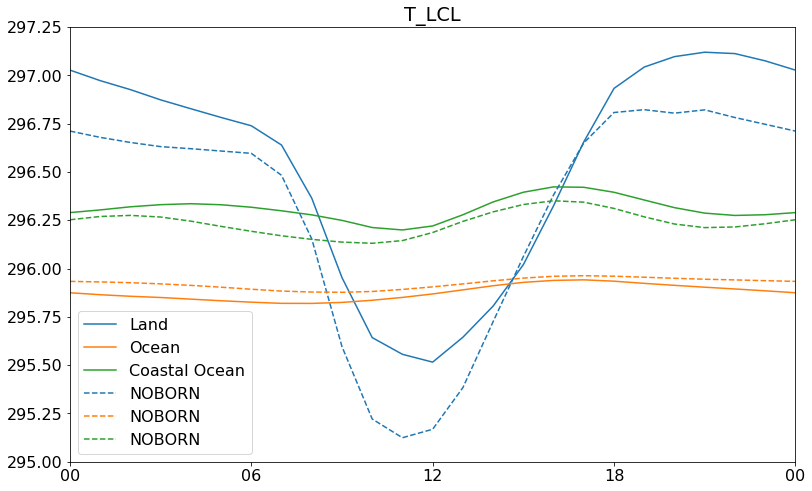

In [26]:
fig = plt.figure(figsize=(13, 8))
plt.rcParams.update({'font.size': 16})

ax=plt.subplot(1,1,1)
plt.xlim(0,24)
plt.xticks([0, 6, 12, 18, 24], ['00', '06', '12', '18', '00'])
plt.title("T_LCL")
plt.ylim(295,297.25)
plt.plot(compute_dcycle_s(all_T_lcl,all_wland), label="Land", color='C0')
plt.plot(compute_dcycle_s(all_T_lcl,all_wocean), label="Ocean", color='C1')
plt.plot(compute_dcycle_s(all_T_lcl,all_coastal_ocean), label="Coastal Ocean", color='C2')
#plt.plot(compute_dcycle_s(all_T_lcl,all_dry_ocean), label="Coastal Ocean", color='C3')

plt.plot(compute_dcycle_s(small_T_lcl,small_wland), label="NOBORN", color='C0', linestyle='--')
plt.plot(compute_dcycle_s(small_T_lcl,small_wocean), label="NOBORN", color='C1', linestyle='--')
plt.plot(compute_dcycle_s(small_T_lcl,small_coastal_ocean), label="NOBORN", color='C2', linestyle='--')
#plt.plot(compute_dcycle_s(small_T_lcl,small_dry_ocean), label="NOBORN", color='C3', linestyle='--')


#plt.gca().invert_yaxis()
plt.legend()

plt.savefig('T_LCL_diurnal_cycle.pdf')

# Distribution with Island Size

In [15]:
def island_properties(fld, islands):
    island_labels = label(islands,neighbors=8)
    island_probs = regionprops(island_labels)

    area = np.zeros(len(island_probs))
    island_mean=np.zeros((len(island_probs)))

    island_probs = regionprops(island_labels,intensity_image=fld)
    for i in range(len(island_probs)):   
        area[i]=island_probs[i].area * 9 #Convert to km2
        island_mean[i]=island_probs[i].mean_intensity
        
    #Sort by isalnd size
    arr1inds = np.argsort(area)

    return area[arr1inds] , island_mean[arr1inds]

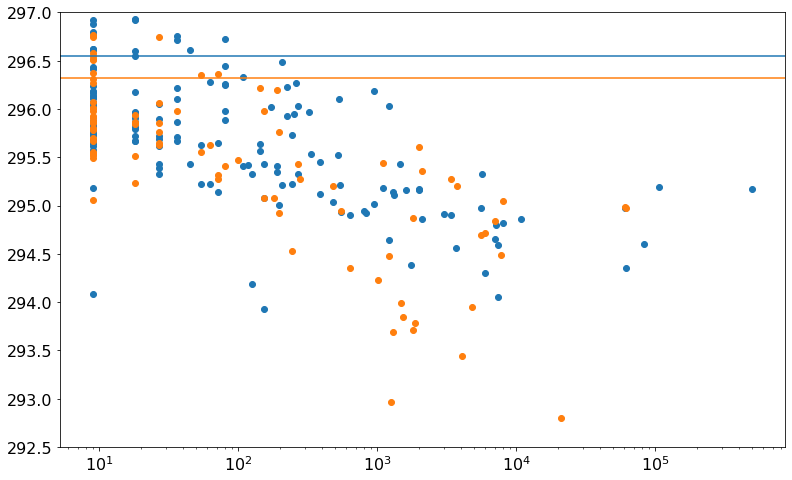

In [28]:
fig = plt.figure(figsize=(13, 8))
plt.rcParams.update({'font.size': 16})


all_wet_islands=island_properties(np.min(all_T_lcl, axis=0), all_wland)
all_dry_islands=island_properties(np.min(all_T_lcl, axis=0), all_fr_land - all_wland)
small_wet_islands=island_properties(np.min(small_T_lcl, axis=0), small_wland)
small_dry_islands=island_properties(np.min(small_T_lcl, axis=0), small_fr_land - small_wland)

plt.scatter(all_wet_islands[0], all_wet_islands[1])
plt.scatter(small_wet_islands[0], small_wet_islands[1])

plt.axhline(y=np.mean(compute_dcycle_s(all_T_lcl,all_wland), axis=0), color='C0')
plt.axhline(y=np.mean(compute_dcycle_s(small_T_lcl,small_wland), axis=0), color='C1')

plt.ylim(292.5,297)
plt.xscale("log")

plt.savefig('T_LCL_island_size.pdf')